In [31]:
import pandas as pd
import numpy as np

precip = pd.read_csv("basin_averaged_climate_data/basin_total_precipitation.csv", index_col=0)
stream = pd.read_csv("combined_streamflow_cleaned.csv", index_col=0)

# Load metadata
meta = pd.read_csv("station_cluster_metadata.csv")

# Filter stations (non-glaciated == True)
non_glaciated_stations = meta.loc[meta["non-glaciated"] == True, "StationNum"].astype(str).tolist()

# Filter the precip/stream tables
precip = precip[non_glaciated_stations]
stream = stream[non_glaciated_stations]

print("Using stations:", non_glaciated_stations)


Using stations: ['05AB029', '05AD035', '05AE005', '05AH037', '05AH041', '05BK001', '05BM014', '05CB001', '05CB004', '05CC001', '05CC007', '05CC010', '05CD006', '05CE006', '05CE010', '05CE011', '05CE018', '05CG004', '05CK001', '05CK005', '05DF007', '05EA005', '05EC005', '05ED002', '05EE005', '05EE006', '05FA001', '05FB002', '05FC002', '05FE002', '07AH002', '07AH003', '07BB005', '07BC007', '07BF001', '07BF002', '07DA018', '07FD006', '07FD011', '07FD013', '07GD001', '07GE003', '07GF001', '07GG001', '07GG003', '07GH002', '07HA003', '07HA005', '07HF002', '07JC001', '07JD003', '07JF002', '07OA001', '07OB004', '07OB006']


In [ ]:
# use this if I only want one station

station_id = "05AE005"

precip_series = precip[station_id].values
stream_series = stream[station_id].values

In [20]:
N = 365  # lookback window

def create_dataset(X, y, N):
    X_out, y_out = [], []
    for i in range(len(X) - N - 1):
        X_out.append(X[i:i+N])
        y_out.append(y[i+N])
    return np.array(X_out), np.array(y_out)

X, y = create_dataset(precip_series, stream_series, N)

# reshape for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))  # (samples, timesteps, features)


In [32]:
N = 365   # lookback window

def create_multi_station_dataset(precip_df, stream_df, N):
    X_all = []
    y_all = []

    for station in precip_df.columns:
        p = precip_df[station].values
        s = stream_df[station].values

        for i in range(len(p) - N - 1):
            X_all.append(p[i:i+N])
            y_all.append(s[i+N])

    X_all = np.array(X_all)
    y_all = np.array(y_all)
    
    # reshape for LSTM
    X_all = X_all.reshape((X_all.shape[0], X_all.shape[1], 1))
    return X_all, y_all

X, y = create_multi_station_dataset(precip, stream, N)
print("Dataset shape:", X.shape, y.shape)


Dataset shape: (843700, 365, 1) (843700,)


In [33]:
split1 = int(0.7 * len(X))
split2 = int(0.9 * len(X))

X_train, y_train = X[:split1], y[:split1]
X_val, y_val = X[split1:split2], y[split1:split2]
X_test, y_test = X[split2:], y[split2:]

In [34]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()

# reshape to 2D (samples, features)
X_train_2d = X_train.reshape(-1, 1)
X_val_2d   = X_val.reshape(-1, 1)
X_test_2d  = X_test.reshape(-1, 1)

X_train_scaled = scaler_x.fit_transform(X_train_2d).reshape(X_train.shape)
X_val_scaled   = scaler_x.transform(X_val_2d).reshape(X_val.shape)
X_test_scaled  = scaler_x.transform(X_test_2d).reshape(X_test.shape)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled   = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled  = scaler_y.transform(y_test.reshape(-1, 1))


In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.LSTM(80, return_sequences=False, input_shape=(N, 1)),
    layers.Dropout(0.1),
    layers.Dense(1)
])

model.compile(optimizer="adam", loss="mse")
model.summary()


C:\Users\tbwil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 80)             │        26,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,321 (102.82 KB)

 Trainable params: 26,321 (102.82 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    validation_data=(X_val_scaled, y_val_scaled),
    epochs=5,
    batch_size=64
)


Epoch 1/5
 156/9228 ━━━━━━━━━━━━━━━━━━━━ 18:09 120ms/step - loss: 0.6639

KeyboardInterrupt: 

In [25]:
def nse(observed, simulated):
    """
    Nash–Sutcliffe Efficiency (NSE)
    """
    return 1 - np.sum((observed - simulated)**2) / np.sum((observed - np.mean(observed))**2)

# Predict validation period
y_val_pred_scaled = model.predict(X_val_scaled)
y_val_pred = scaler_y.inverse_transform(y_val_pred_scaled)

# True values already in y_val (unscaled)
y_val_true = y_val

val_nse = nse(y_val_true, y_val_pred.flatten())
print("Validation NSE:", val_nse)

96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step
Validation NSE: 0.384776073996289


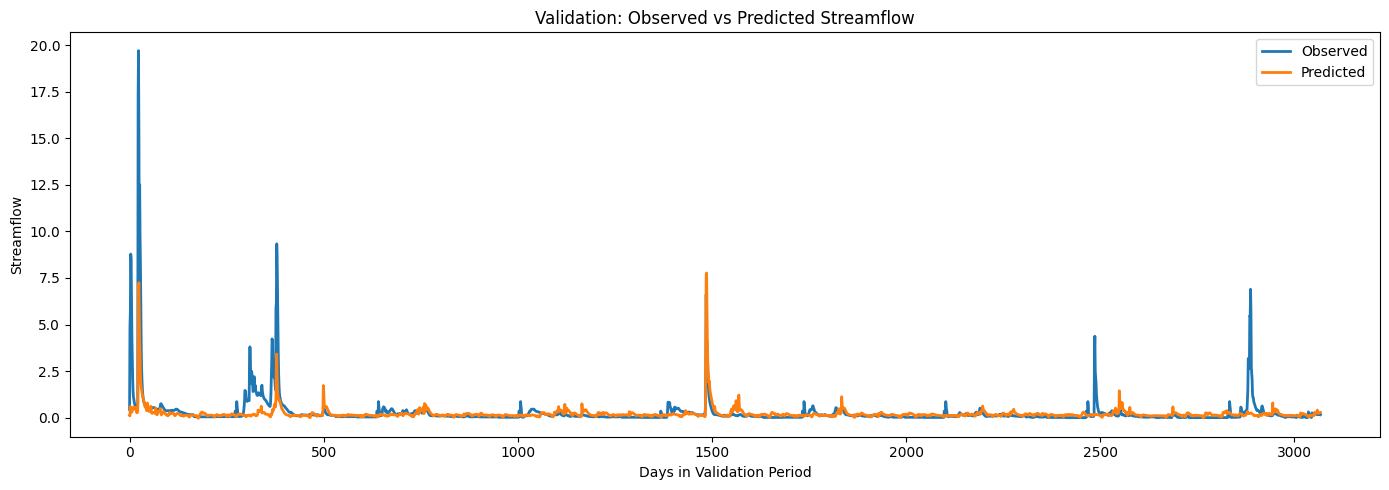

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
plt.plot(y_val_true, label="Observed", linewidth=2)
plt.plot(y_val_pred, label="Predicted", linewidth=2)
plt.title("Validation: Observed vs Predicted Streamflow")
plt.xlabel("Days in Validation Period")
plt.ylabel("Streamflow")
plt.legend()
plt.tight_layout()
plt.show()


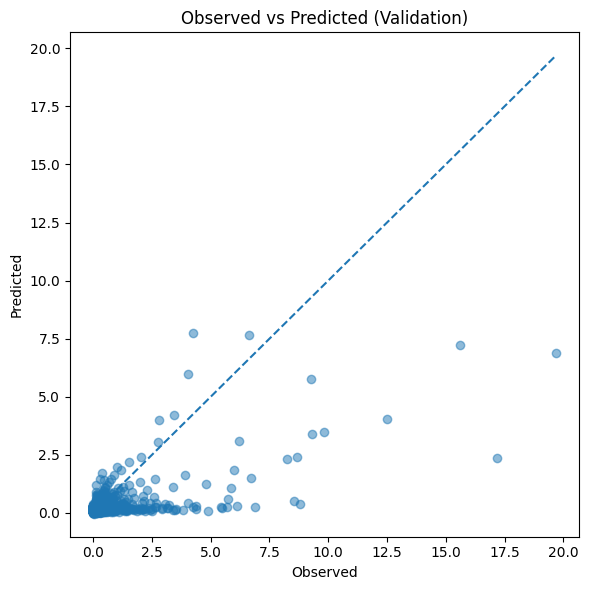

In [29]:
plt.figure(figsize=(6, 6))
plt.scatter(y_val_true, y_val_pred, alpha=0.5)
plt.plot([min(y_val_true), max(y_val_true)],
         [min(y_val_true), max(y_val_true)], 
         linestyle="--")
plt.xlabel("Observed")
plt.ylabel("Predicted")
plt.title("Observed vs Predicted (Validation)")
plt.tight_layout()
plt.show()
